<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Bintangor/Bintangor_LIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_bintangor"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [4]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_bintangor
Rows: 11548
Columns: 16
Shape: (11548, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
4.864101409912109

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,11548.0,5.680615,3.949815,0.000000,2.600000,5.075000,8.000000,23.000000
To,11548.0,6.448785,3.934414,0.200000,3.000000,6.000000,9.000000,23.900000
Interval,11548.0,0.768170,0.290259,0.050000,0.500000,1.000000,1.000000,3.000000
CoreRec,11548.0,1.081167,0.188022,0.200000,1.000000,1.000000,1.090000,3.500000
WetW,11548.0,4.179988,1.862441,0.400000,2.640000,4.259500,5.515000,13.340000
H2O,11548.0,25.032835,14.841084,0.079000,12.402250,25.364500,36.083250,90.147000
DryW,11548.0,3.181767,1.628951,0.156000,1.835000,3.057500,4.336000,11.840000
WTF,11548.0,1.756388,0.571895,0.195304,1.489770,1.723069,1.953043,23.925631
DTF,11548.0,1.335409,0.587918,0.123134,0.992927,1.266640,1.612504,22.471965



Unique GEN_LYR count: 5
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,5803
BRK,2925
SAP,2291
SAPX,312
LIMX,217



Unique Material count: 50
Top Material value counts:


,count
Material,
YLIM,2423
Rlim,1583
ESAP,1572
HGT,933
HSAP,882
RSAP,831
Sap,700
RLIM,380
DNT,365



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [23]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: LIM
Masukkan Material yang ingin difilter (pisahkan dengan koma): Rlim,Irc,IRC,RLIM,GRAV_1,BS_1,YS_1,BS,YLIM,GRAV,VIR,GRAV_2,BS_2,ESAP,YS,RSAP,GS,BS_3,GRAV_3,GRAV_4,Sap,GRAV_5,GRAV_6,YS_6,GRAV_7

Filtered rows: 5795


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1,CS7210158,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.10,7.390,19.350,5.960,Rlim,None,ESAP,LIM,2.297880,1.853230
3,CS7210156R,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,0.6,0.6,1.16,4.140,9.662,3.740,Irc,None,ESAP,LIM,2.034543,1.837968
4,CS7210176,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.00,6.610,22.088,5.150,Rlim,None,ESAP,LIM,2.260878,1.761501
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.00,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349
6,CS6210013R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.00,6.757,21.385,5.312,Rlim,None,LIM,LIM,4.622316,3.633823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,CS6210175,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,4.448,35.567,2.866,Rlim,None,LIM,LIM,1.521390,0.980284
139,CS6210072,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,7.037,24.229,5.332,Rlim,None,LIM,LIM,2.406929,1.823752
140,CS7210079,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.00,4.442,26.970,3.244,Rlim,None,LIM,LIM,1.519337,1.109575
141,CS6210077,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,8.165,25.168,6.110,Rlim,None,LIM,LIM,2.792749,2.089859


# Filter By Interval

Descriptive statistics for Interval:
Count: 5795
Mean: 0.799113
Standard Error: 0.003560
Median: 1.0
Mode: 1.0
Standard Deviation: 0.271008
Sample Variance: 0.073445
Kurtosis: -0.754531
Skewness: -0.762828
Range: 1.55
Minimum: 0.05
Maximum: 1.6
Sum: 4630.86
Confidence Level (95%): ±0.006979

Bin calculation:
Freedman–Diaconis -> bins: 31, bin width: 0.050106
Sturges -> bins: 14, bin width: 0.110714


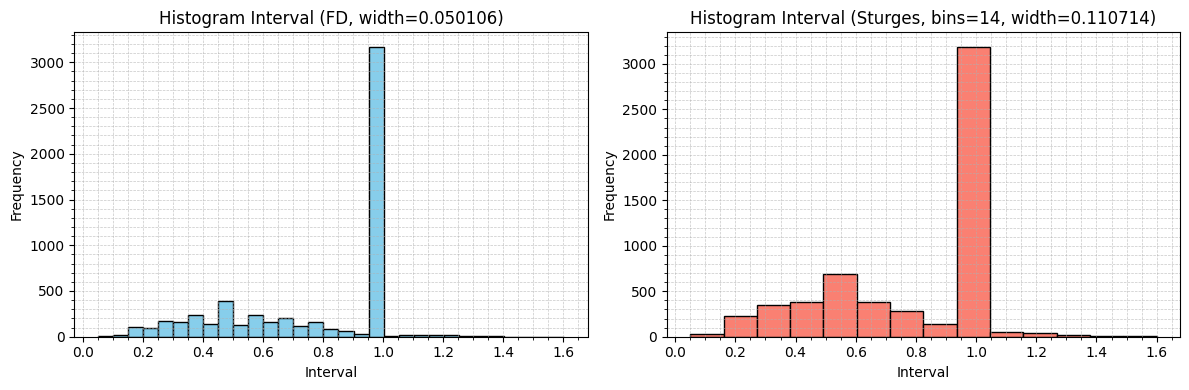


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.050000,0.100106,4
1,0.100106,0.150212,22
2,0.150212,0.200319,102
3,0.200319,0.250425,94
4,0.250425,0.300531,175
5,0.300531,0.350637,156
6,0.350637,0.400743,237
7,0.400743,0.450850,141
8,0.450850,0.500956,388
9,0.500956,0.551062,131



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.050000,0.160714,32
1,0.160714,0.271429,227
2,0.271429,0.382143,351
3,0.382143,0.492857,384
4,0.492857,0.603571,694
5,0.603571,0.714286,381
6,0.714286,0.825000,282
7,0.825000,0.935714,141
8,0.935714,1.046429,3187
9,1.046429,1.157143,50


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [25]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.160714
Masukkan batas atas (is less than or equal to): 1.046429

Filtered rows: 5647


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1,CS7210158,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.10,7.390,19.350,5.960,Rlim,None,ESAP,LIM,2.297880,1.853230
3,CS7210156R,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,0.60,0.60,1.16,4.140,9.662,3.740,Irc,None,ESAP,LIM,2.034543,1.837968
4,CS7210176,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.00,6.610,22.088,5.150,Rlim,None,ESAP,LIM,2.260878,1.761501
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.50,0.50,1.00,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349
6,CS6210013R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.50,0.50,1.00,6.757,21.385,5.312,Rlim,None,LIM,LIM,4.622316,3.633823
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.80,0.80,1.00,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939
8,CD500098,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,6.915,8.344,6.338,IRC,None,LIM,LIM,2.365200,2.167843
9,CD500139,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,5.092,11.646,4.499,IRC,None,LIM,LIM,1.741663,1.538834
10,CD500162,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,5.833,12.978,5.076,IRC,None,LIM,LIM,1.995114,1.736190
11,CD500084,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.00,1.00,1.00,7.005,18.558,5.705,IRC,None,LIM,LIM,2.395983,1.951333


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 5647
Mean: 1.121638
Standard Error: 0.002712
Median: 1.0
Mode: 1.0
Standard Deviation: 0.203800
Sample Variance: 0.041534
Kurtosis: 3.644201
Skewness: 1.655366
Range: 2.25
Minimum: 0.5
Maximum: 2.75
Sum: 6333.889999999999
Confidence Level (95%): ±0.005317

Bin calculation:
Freedman–Diaconis -> bins=81, width=0.028078
Sturges -> bins=14, width=0.160714


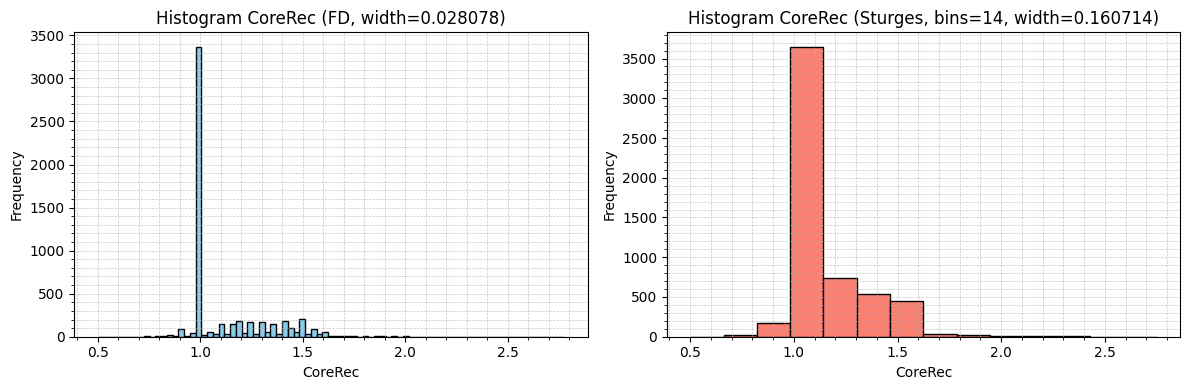


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.500000,0.528078,1
1,0.528078,0.556156,0
2,0.556156,0.584234,0
3,0.584234,0.612311,0
4,0.612311,0.640389,0
...,...,...,...
76,2.633918,2.661996,0
77,2.661996,2.690073,0
78,2.690073,2.718151,0
79,2.718151,2.746229,0



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.500000,0.660714,2
1,0.660714,0.821429,20
2,0.821429,0.982143,170
3,0.982143,1.142857,3647
4,1.142857,1.303571,739
5,1.303571,1.464286,541
6,1.464286,1.625000,450
7,1.625000,1.785714,38
8,1.785714,1.946429,16
9,1.946429,2.107143,13


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [27]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.982143
Masukkan batas atas (is less than or equal to): 1.142857

Filtered rows: 3647


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
1,CS7210158,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.1,7.390,19.350,5.960,Rlim,None,ESAP,LIM,2.297880,1.853230
4,CS7210176,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,6.610,22.088,5.150,Rlim,None,ESAP,LIM,2.260878,1.761501
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.50,0.50,1.0,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349
6,CS6210013R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.50,0.50,1.0,6.757,21.385,5.312,Rlim,None,LIM,LIM,4.622316,3.633823
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.80,0.80,1.0,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939
8,CD500098,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,6.915,8.344,6.338,IRC,None,LIM,LIM,2.365200,2.167843
9,CD500139,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,5.092,11.646,4.499,IRC,None,LIM,LIM,1.741663,1.538834
10,CD500162,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,5.833,12.978,5.076,IRC,None,LIM,LIM,1.995114,1.736190
11,CD500084,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.00,1.00,1.0,7.005,18.558,5.705,IRC,None,LIM,LIM,2.395983,1.951333
12,CS7210240,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,8.730,23.826,6.650,Irc,None,LIM,LIM,2.986001,2.274560


# Filter By Wet Weight


Residual IQR acuan:
Q1: -0.750, Q3: 0.576, IQR: 1.326
Lower margin: -2.739, Upper margin: 2.565


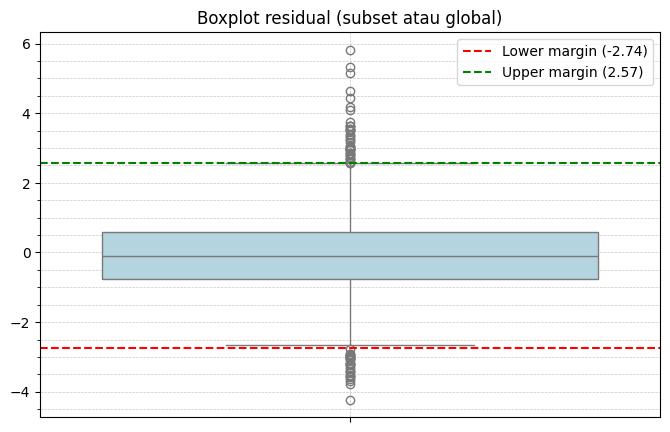

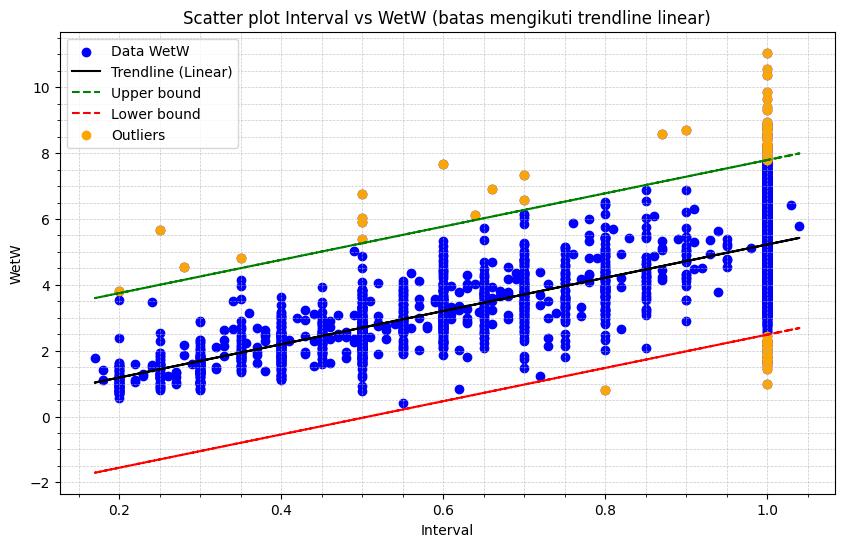


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
         HoleId                       Hill Hill_Group  From   To  Interval  \
6    CS6210013R  Bintangor Blok 2 Spasi 25  BINTANGOR   0.0  0.5       0.5   
12    CS7210240  Bintangor Blok 1 Spasi 50  BINTANGOR   0.0  1.0       1.0   
40    CS7210056  Bintangor Blok 2 Spasi 50  BINTANGOR   0.0  1.0       1.0   
58   CS7210189R  Bintangor Blok 1 Spasi 50  BINTANGOR   0.0  1.0       1.0   
124    CD500129    BINTANGOR BARAT SELATAN  BINTANGOR   0.0  1.0       1.0   

     CoreRec   WetW     H2O   DryW Material Layer NEW_LYR GEN_LYR       WTF  \
6        1.0  6.757  21.385  5.312     Rlim  None     LIM     LIM  4.622316   
12       1.0  8.730  23.826  6.650      Irc  None     LIM     LIM  2.986001   
40       1.0  7.822  22.181  6.087     Rlim  None     LIM     LIM  2.675429   
58       1.0  8.195  14.643  6.995     Rlim  None     LIM     LIM  2.803010   
124      1.0  2.303   7.686  2.126      IRC  None     LIM     LIM  0.78

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [29]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
1,CS7210158,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.10,7.390,19.350,5.960,Rlim,None,ESAP,LIM,2.297880,1.853230,7.390
4,CS7210176,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.00,6.610,22.088,5.150,Rlim,None,ESAP,LIM,2.260878,1.761501,6.610
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.00,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349,3.828
6,CS6210013R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.00,6.757,21.385,5.312,Rlim,None,LIM,LIM,4.622316,3.633823,6.757
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.8,0.8,1.00,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939,5.751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10177,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,10.4,11.0,0.6,1.08,4.375,36.777,2.766,YLIM,None,LIM,LIM,2.309291,1.460000,4.375
10506,CS7210086,Bintangor Blok 2 Spasi 50,BINTANGOR,11.0,11.6,0.6,1.00,2.730,46.374,1.464,YLIM,None,LIM,LIM,1.556278,0.834575,2.730
10507,CS6210167,Bintangor Blok 2 Spasi 25,BINTANGOR,11.0,11.4,0.4,1.00,1.715,46.414,0.919,Sap,None,LIM,LIM,1.466492,0.785835,1.715
10508,CS6210121,Bintangor Blok 2 Spasi 25,BINTANGOR,11.0,12.0,1.0,1.00,3.635,46.520,1.944,Sap,None,LIM,LIM,1.243312,0.664924,3.635



Residual IQR acuan:
Q1: -0.750, Q3: 0.576, IQR: 1.326
Lower margin: -2.739, Upper margin: 2.565


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


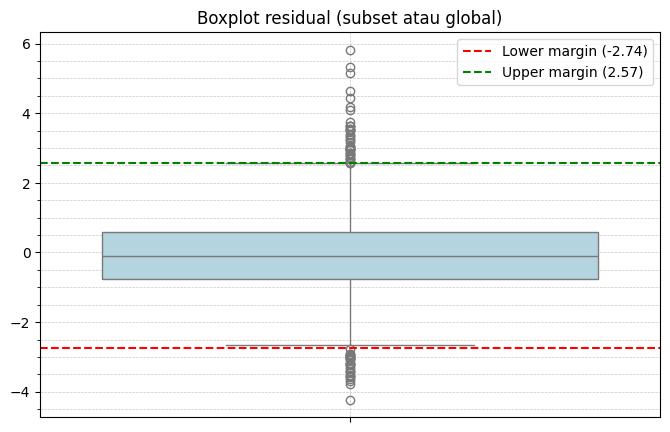

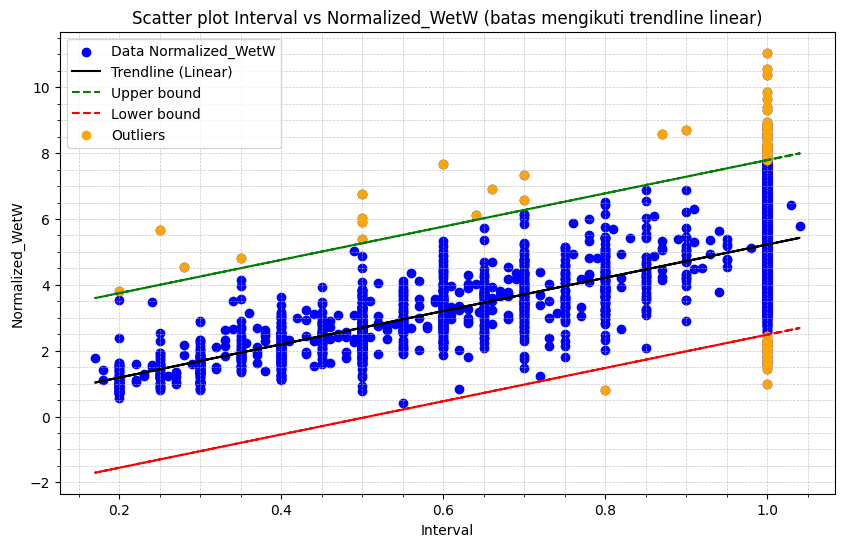

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
1,CS7210158,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.1,7.390,19.350,5.960,Rlim,None,ESAP,LIM,2.297880,1.853230,7.390,5.223993,Normal
4,CS7210176,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,6.610,22.088,5.150,Rlim,None,ESAP,LIM,2.260878,1.761501,6.610,5.223993,Normal
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.0,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349,3.828,2.698325,Normal
6,CS6210013R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.0,6.757,21.385,5.312,Rlim,None,LIM,LIM,4.622316,3.633823,6.757,2.698325,Outlier atas
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.8,0.8,1.0,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939,5.751,4.213726,Normal
8,CD500098,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,6.915,8.344,6.338,IRC,None,LIM,LIM,2.365200,2.167843,6.915,5.223993,Normal
9,CD500139,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,5.092,11.646,4.499,IRC,None,LIM,LIM,1.741663,1.538834,5.092,5.223993,Normal
10,CD500162,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,5.833,12.978,5.076,IRC,None,LIM,LIM,1.995114,1.736190,5.833,5.223993,Normal
11,CD500084,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.0,1.0,1.0,7.005,18.558,5.705,IRC,None,LIM,LIM,2.395983,1.951333,7.005,5.223993,Normal
12,CS7210240,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,8.730,23.826,6.650,Irc,None,LIM,LIM,2.986001,2.274560,8.730,5.223993,Outlier atas


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=37, width=0.290399
Sturges -> bins=13, width=0.819231


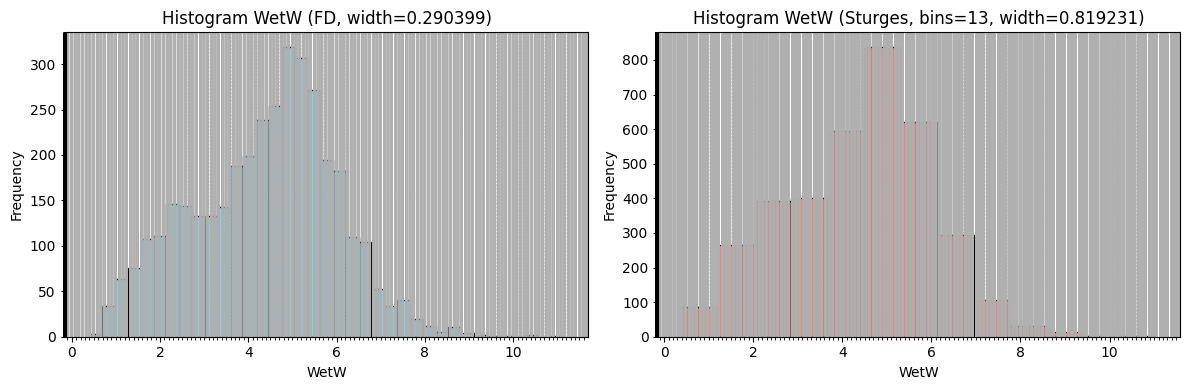


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.400000,0.690399,3
1,0.690399,0.980799,34
2,0.980799,1.271198,64
3,1.271198,1.561597,76
4,1.561597,1.851997,107
5,1.851997,2.142396,111
6,2.142396,2.432795,146
7,2.432795,2.723195,144
8,2.723195,3.013594,133
9,3.013594,3.303993,133



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.400000,1.219231,87
1,1.219231,2.038462,265
2,2.038462,2.857692,391
3,2.857692,3.676923,401
4,3.676923,4.496154,595
5,4.496154,5.315385,838
6,5.315385,6.134615,621
7,6.134615,6.953846,294
8,6.953846,7.773077,107
9,7.773077,8.592308,30


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [38]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 3.676923
Masukkan batas atas (<=): 6.134615

Filtered rows (Normal only): 2046


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.0,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349,3.828,2.698325
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.8,0.8,1.0,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939,5.751,4.213726
9,CD500139,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,5.092,11.646,4.499,IRC,None,LIM,LIM,1.741663,1.538834,5.092,5.223993
10,CD500162,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,5.833,12.978,5.076,IRC,None,LIM,LIM,1.995114,1.736190,5.833,5.223993
15,CS6210163,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.827,20.655,3.830,Rlim,None,LIM,LIM,1.651022,1.310010,4.827,5.223993
16,CS7210206,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.670,19.489,4.565,Rlim,None,LIM,LIM,1.939361,1.561408,5.670,5.223993
19,CD500136,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,4.872,14.696,4.156,IRC,None,LIM,LIM,1.666414,1.421514,4.872,5.223993
24,CS7210002R,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,3.748,18.036,3.072,Rlim,None,LIM,LIM,1.281962,1.050744,3.748,5.223993
25,CS6210008,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.925,29.316,4.188,Rlim,None,LIM,LIM,2.026581,1.432460,5.925,5.223993
26,CS7210289,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.180,25.359,3.120,Rlim,None,LIM,LIM,1.429723,1.067162,4.180,5.223993


#Filter By MC


Descriptive statistics for H2O:
Count: 2046
Mean: 27.638262
Standard Error: 0.201198
Median: 27.604
Mode: 27.664
Standard Deviation: 9.100741
Sample Variance: 82.823486
Kurtosis: 0.678079
Skewness: 0.220315
Range: 83.067
Minimum: 0.277
Maximum: 83.344
Sum: 56547.884
Confidence Level (95%): ±0.394575

Bin calculation:
Freedman–Diaconis -> bins=44, width=1.908969
Sturges -> bins=12, width=6.922250


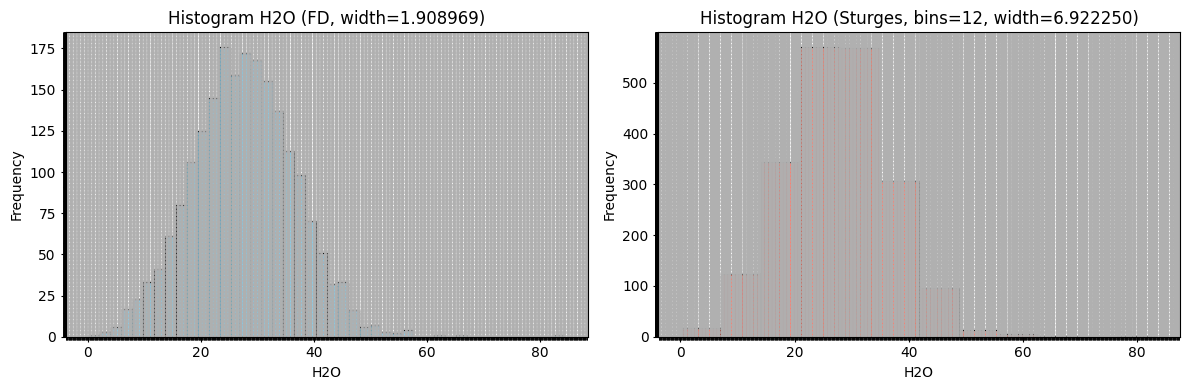


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.277000,2.185969,1
1,2.185969,4.094938,3
2,4.094938,6.003907,6
3,6.003907,7.912876,17
4,7.912876,9.821845,23
5,9.821845,11.730813,33
6,11.730813,13.639782,41
7,13.639782,15.548751,61
8,15.548751,17.457720,80
9,17.457720,19.366689,106



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.27700,7.19925,17
1,7.19925,14.12150,123
2,14.12150,21.04375,344
3,21.04375,27.96600,571
4,27.96600,34.88825,568
5,34.88825,41.81050,306
6,41.81050,48.73275,96
7,48.73275,55.65500,14
8,55.65500,62.57725,5
9,62.57725,69.49950,1


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [40]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 21.04375
is less than or equal to: 34.88825

Filtered rows (H2O): 1139


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
5,CS6210144,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.5,0.5,1.0,3.828,23.459,2.930,Rlim,None,LIM,LIM,2.618651,2.004349,3.828,2.698325
7,CS6210118,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,0.8,0.8,1.0,5.751,23.665,4.390,Rlim,None,LIM,LIM,2.458833,1.876939,5.751,4.213726
25,CS6210008,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.925,29.316,4.188,Rlim,None,LIM,LIM,2.026581,1.432460,5.925,5.223993
26,CS7210289,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.180,25.359,3.120,Rlim,None,LIM,LIM,1.429723,1.067162,4.180,5.223993
27,CS7210272,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,3.850,23.896,2.930,Rlim,None,LIM,LIM,1.316850,1.002174,3.850,5.223993
28,CS6210095R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.965,24.411,3.753,Rlim,None,LIM,LIM,1.698224,1.283673,4.965,5.223993
34,CD500077,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.0,1.0,1.0,5.184,25.540,3.860,RLIM,None,LIM,LIM,1.773130,1.320271,5.184,5.223993
38,CS7210354,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.560,31.360,3.130,Rlim,None,LIM,LIM,1.559698,1.070582,4.560,5.223993
41,CS7210048,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.218,21.847,4.078,Rlim,None,LIM,LIM,1.784760,1.394835,5.218,5.223993
52,CD500088,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.0,1.0,1.0,5.045,27.453,3.660,RLIM,None,LIM,LIM,1.725587,1.251863,5.045,5.223993


# Filter By DTF


Descriptive statistics for DTF:
Count: 1139
Mean: 1.267375
Standard Error: 0.005911
Median: 1.255625321
Mode: 1.286066795
Standard Deviation: 0.199475
Sample Variance: 0.039790
Kurtosis: 3.516460
Skewness: 1.009164
Range: 1.7625760430000001
Minimum: 0.829102636
Maximum: 2.591678679
Sum: 1443.540177759
Confidence Level (95%): ±0.011597

Bin calculation:
Freedman–Diaconis -> bins=41, width=0.043970
Sturges -> bins=12, width=0.146881


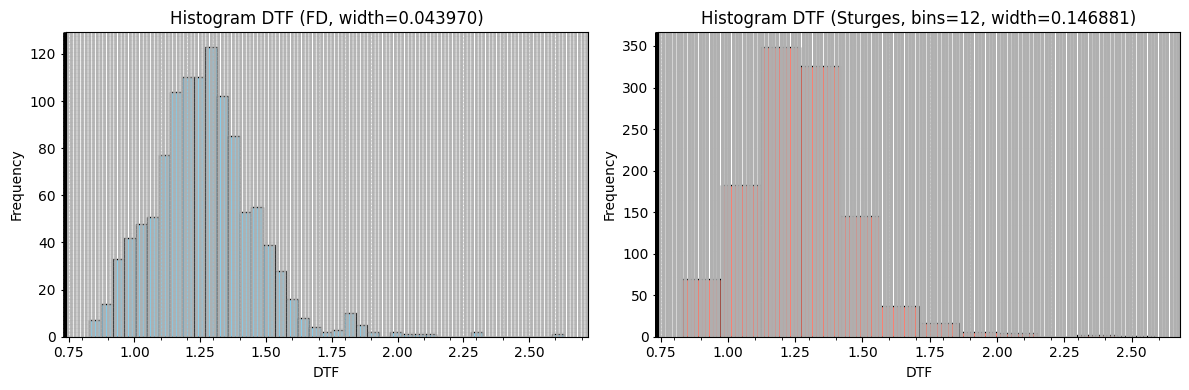


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.829103,0.873072,7
1,0.873072,0.917042,14
2,0.917042,0.961012,33
3,0.961012,1.004981,42
4,1.004981,1.048951,48
5,1.048951,1.092921,51
6,1.092921,1.136890,77
7,1.136890,1.180860,104
8,1.180860,1.224830,110
9,1.224830,1.268799,110



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.829103,0.975984,69
1,0.975984,1.122865,183
2,1.122865,1.269747,349
3,1.269747,1.416628,326
4,1.416628,1.563509,145
5,1.563509,1.710391,37
6,1.710391,1.857272,17
7,1.857272,2.004153,6
8,2.004153,2.151035,4
9,2.151035,2.297916,0


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [42]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 1.122865
is less than or equal to: 1.416628

Filtered rows (DTF): 675


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
28,CS6210095R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.00,1.00,1.0,4.965,24.411,3.753,Rlim,None,LIM,LIM,1.698224,1.283673,4.965,5.223993
34,CD500077,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.00,1.00,1.0,5.184,25.540,3.860,RLIM,None,LIM,LIM,1.773130,1.320271,5.184,5.223993
41,CS7210048,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,5.218,21.847,4.078,Rlim,None,LIM,LIM,1.784760,1.394835,5.218,5.223993
52,CD500088,BINTANGOR BARAT UTARA,BINTANGOR,0.0,1.00,1.00,1.0,5.045,27.453,3.660,RLIM,None,LIM,LIM,1.725587,1.251863,5.045,5.223993
64,CS7210339,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,0.87,0.87,1.0,4.240,25.236,3.170,Rlim,None,LIM,LIM,1.666949,1.246280,4.240,4.567319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,CS7210171,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,4.910,21.487,3.855,Rlim,None,LIM,LIM,1.679412,1.318561,4.910,5.223993
666,CS7210087,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,4.566,27.902,3.292,Rlim,None,LIM,LIM,1.561750,1.125993,4.566,5.223993
674,CS7210046,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,5.318,25.310,3.972,Rlim,None,LIM,LIM,1.818964,1.358579,5.318,5.223993
689,CS6210037,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.00,1.00,1.0,5.315,27.526,3.852,Rlim,None,LIM,LIM,1.817938,1.317534,5.315,5.223993


# SUMMARY

In [43]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 675
Mean: 0.980222
Standard Error: 0.002588
Median: 1.0
Mode: 1.0
Standard Deviation: 0.067242
Sample Variance: 0.004521
Kurtosis: 12.217858
Skewness: -3.573390
Range: 0.43000000000000005
Minimum: 0.61
Maximum: 1.04
Sum: 661.65
Confidence Level (95%): ±0.005082

Descriptive statistics for CoreRec:
Count: 675
Mean: 1.007111
Standard Error: 0.000940
Median: 1.0
Mode: 1.0
Standard Deviation: 0.024424
Sample Variance: 0.000597
Kurtosis: 10.615305
Skewness: 3.431403
Range: 0.1399999999999999
Minimum: 1.0
Maximum: 1.14
Sum: 679.8
Confidence Level (95%): ±0.001846

Descriptive statistics for WetW:
Count: 675
Mean: 5.095428
Standard Error: 0.018234
Median: 5.125
Mode: 5.19
Standard Deviation: 0.473721
Sample Variance: 0.224412
Kurtosis: 0.184028
Skewness: -0.514614
Range: 2.4099999999999997
Minimum: 3.722
Maximum: 6.132
Sum: 3439.414
Confidence Level (95%): ±0.035801

Descriptive statistics for H2O:
Count: 675
Mean: 28.301963
Standard Error: 0.14199

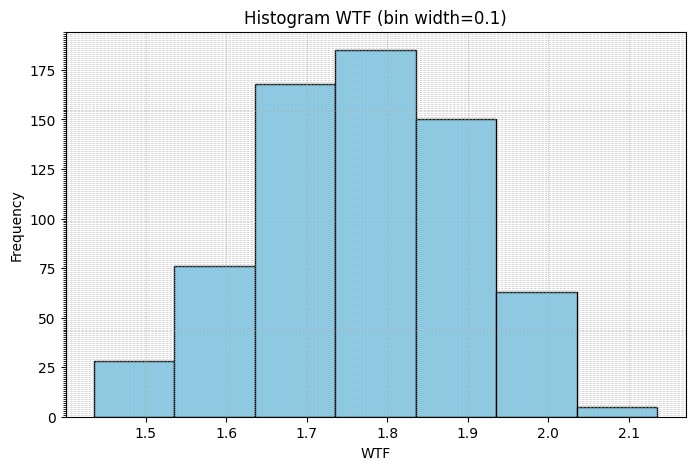


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.435538,1.535538,28
1,1.535538,1.635538,76
2,1.635538,1.735538,168
3,1.735538,1.835538,185
4,1.835538,1.935538,150
5,1.935538,2.035538,63
6,2.035538,2.135538,5


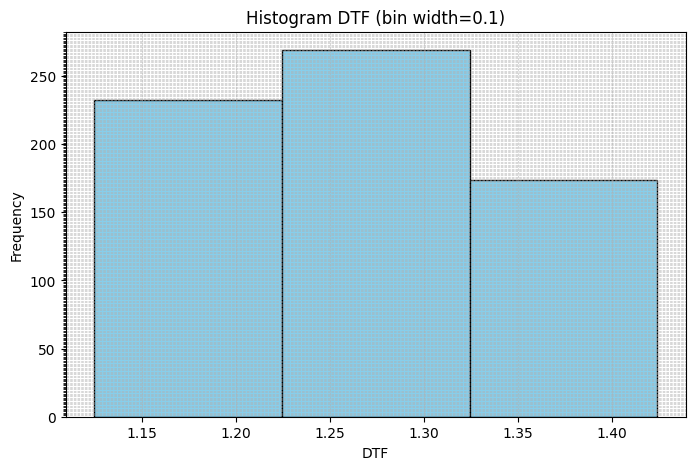


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,1.124207,1.224207,232
1,1.224207,1.324207,269
2,1.324207,1.424207,174


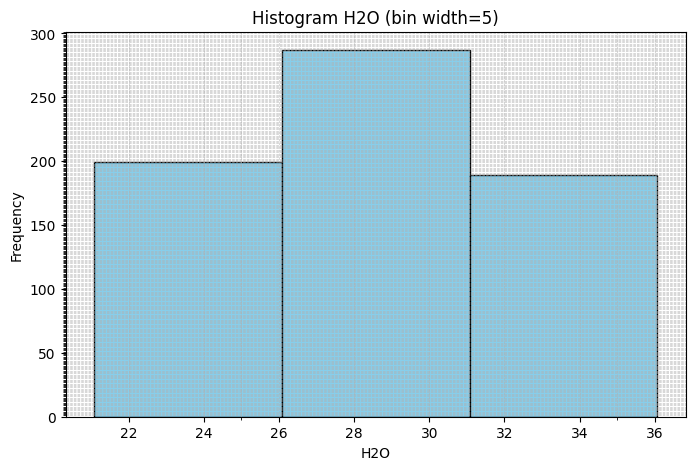


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,21.073,26.073,199
1,26.073,31.073,287
2,31.073,36.073,189


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [45]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Bintangor
Masukkan GEN_LYR: LIM

Tabel Ringkasan tersimpan sebagai variabel: df_bintangor_lim


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Bintangor,LIM,0.980222,1.007111,5.095428,28.301963,3.646699,1.767598,1.264818
